In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# DOWNLOAD FILE LIBRARY

In [2]:
!pip3 install vncorenlp
!pip install -q tf-models-official

     |████████████████████████████████| 2.7MB 5.0MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=c423c64bfbd11d2e23eefee2de0e5eb7f09f1a09ca07687796dcd5b475347ad9
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
     |████████████████████████████████| 1.6MB 7.0MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 1.2MB 25.0MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 686kB 41.8MB/s 
     |████████████████████████████████| 358kB 24.9MB/s 
     |████████████████████████████████| 645kB 42.8MB/s 
     |████████████████████████████████| 38.2MB 67kB/s 
     |████████████████████████████████| 215kB 42.4MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 


In [3]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

In [4]:
# annotator = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

# def preprocessing(row):
#   def tokenizer(row):
#     row = annotator.tokenize(row)
#     return ' '.join([' '.join(words) for words in row])
#   return tokenizer(row)

# IMPORT LIBRARY AND PATH DATASET

In [5]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from official.nlp import optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

np.random.seed(7)

In [6]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSMEC/BiGRU/images')
MODEL_PATH = os.path.join(path_root, 'model/VSMEC/BiGRU')
name_model = 'VSMEC_BiGRU'

path_VSMEC_train = os.path.join(path_root, 'data/UIT-VSMEC/train_nor_811.xlsx')
path_VSMEC_test = os.path.join(path_root, 'data/UIT-VSMEC/test_nor_811.xlsx')
path_VSMEC_dev = os.path.join(path_root, 'data/UIT-VSMEC/valid_nor_811.xlsx')

# DATA LOADER AND PREPROCESSING

In [7]:
df_train = pd.read_excel(path_VSMEC_train).iloc[:,1:]
df_test = pd.read_excel(path_VSMEC_test).iloc[:,1:]
df_dev = pd.read_excel(path_VSMEC_dev).iloc[:,1:]

In [8]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def preprocessing(row):
  def tokenizer(row):
    row = annotator.tokenize(row)
    return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

In [9]:
df_train.loc[:, 'Sentence'] = df_train.loc[:, 'Sentence'].apply(preprocessing)
df_test.loc[:, 'Sentence'] = df_test.loc[:, 'Sentence'].apply(preprocessing)
df_dev.loc[:, 'Sentence'] = df_dev.loc[:, 'Sentence'].apply(preprocessing)

In [10]:
df_train.head(5)

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng_đời con quỷ . về nhà lôi con nhà mày ...
2,Disgust,lo học đi . yêu_đương lol gì hay lại thích học...
3,Enjoyment,uớc gì sau_này về già vẫn có_thể như cụ này : ) )
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


In [11]:
# Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_300dims.txt'))

In [12]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 128
DROPOUT = 0.5
nclasses = len(df_train['Emotion'].unique())
EMBEDDING_DIM = 300
BATCH_SIZE = 50
EPOCH = 10
lr = 1e-2
STEPS_PER_EPOCH = len(df_train['Sentence']) // BATCH_SIZE
VALIDATION_STEPS = len(df_dev['Sentence']) // BATCH_SIZE

In [13]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['Sentence'])
word_index = tokenizer.word_index

In [14]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [15]:
labels = {emo:id_  for id_, emo in enumerate(list(df_train['Emotion'].unique()))}
def label_encoder(row):
  row = labels[row]
  return row

In [16]:
X_train = prepare_input(df_train['Sentence'], tokenizer)
Y_train = np.array(df_train['Emotion'].apply(label_encoder).tolist())

X_dev = prepare_input(df_dev['Sentence'], tokenizer)
Y_dev = np.array(df_dev['Emotion'].apply(label_encoder).tolist())

In [17]:
# # Create embedding matrix 
# def create_embedding(EMBEDDING_DIM, word_index, embedding_dict):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(EMBEDDING_DIM, word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_VSMEC.npy'), embedding_matrix)

In [18]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_VSMEC.npy'))

# Fine-tuning with TensorFlow

## Define the model

In [19]:
def create_model(word_index, embedding_matrix, optimizer, nclasses=nclasses, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=EMBEDDING_DIM, dropout=DROPOUT, gru_node=32):
  model = Sequential()
  
  model.add(Embedding(len(word_index) + 1,
                      EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True))
  
  model.add(Bidirectional(GRU(gru_node, return_sequences=True)))
  model.add(Bidirectional(GRU(gru_node)))
  model.add(Dropout(dropout))
  
  model.add(Dense(nclasses, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
  return model

## Optimizer

In [20]:
optimizer = 'adam'

## Callbacks

In [21]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    verbose = 1
)

## Training

In [22]:
model = create_model(word_index, embedding_matrix, optimizer, nclasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, DROPOUT, 128)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 300)          1319700   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          330240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 1799      
Total params: 1,948,187
Trainable params: 1,948,187
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, Y_train,
                              validation_data=(X_dev, Y_dev),
                              epochs=EPOCH,
                              batch_size=BATCH_SIZE,
                              callbacks = [
                                  early_stop_callback, 
                                  checkpoint_callback
                              ],
                              verbose=1)

Epoch 1/10
111/111 [==============================] - 130s 1s/step - loss: 1.8857 - accuracy: 0.2500 - val_loss: 1.7088 - val_accuracy: 0.3149
Epoch 2/10
111/111 [==============================] - 121s 1s/step - loss: 1.7467 - accuracy: 0.3082 - val_loss: 1.6132 - val_accuracy: 0.3513
Epoch 3/10
111/111 [==============================] - 122s 1s/step - loss: 1.5370 - accuracy: 0.4088 - val_loss: 1.4784 - val_accuracy: 0.4402
Epoch 4/10
111/111 [==============================] - 122s 1s/step - loss: 1.2954 - accuracy: 0.5110 - val_loss: 1.3721 - val_accuracy: 0.4883
Epoch 5/10
111/111 [==============================] - 121s 1s/step - loss: 1.0516 - accuracy: 0.6179 - val_loss: 1.3041 - val_accuracy: 0.5233
Epoch 6/10
111/111 [==============================] - 122s 1s/step - loss: 0.8761 - accuracy: 0.6866 - val_loss: 1.5414 - val_accuracy: 0.4679
Epoch 7/10
111/111 [==============================] - 122s 1s/step - loss: 0.7271 - accuracy: 0.7430 - val_loss: 1.3412 - val_accuracy: 0.5190

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 300)          1319700   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          330240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 1799      
Total params: 1,948,187
Trainable params: 1,948,187
Non-trainable params: 0
_________________________________________________________________


# Predict on test data

In [25]:
X_test = prepare_input(df_test['Sentence'], tokenizer)
y_test = np.array(df_test['Emotion'].apply(label_encoder).tolist())

In [27]:
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).argmax(axis=-1)
metric = metrics.classification_report(y_test, y_pred, output_dict=True)
print(metrics.classification_report(y_test, y_pred, target_names=labels, digits=4))


 Evaluating Model ... 

14/14 [==============================] - 4s 260ms/step
              precision    recall  f1-score   support

       Other     0.3473    0.7054    0.4655       129
     Disgust     0.5283    0.4242    0.4706       132
   Enjoyment     0.7073    0.4508    0.5506       193
       Anger     0.4286    0.4500    0.4390        40
    Surprise     0.7000    0.1892    0.2979        37
     Sadness     0.6250    0.5603    0.5909       116
        Fear     0.6739    0.6739    0.6739        46

    accuracy                         0.5123       693
   macro avg     0.5729    0.4934    0.4983       693
weighted avg     0.5737    0.5123    0.5145       693



In [28]:
f1 = round(metric['macro avg']['f1-score'], 4)
name_model = name_model + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.h5'
name_img_ = 'loss' + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
model.save_weights(os.path.join(MODEL_PATH, name_model))

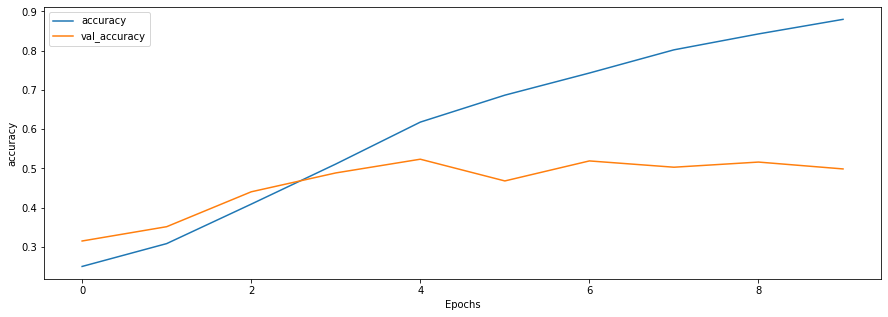

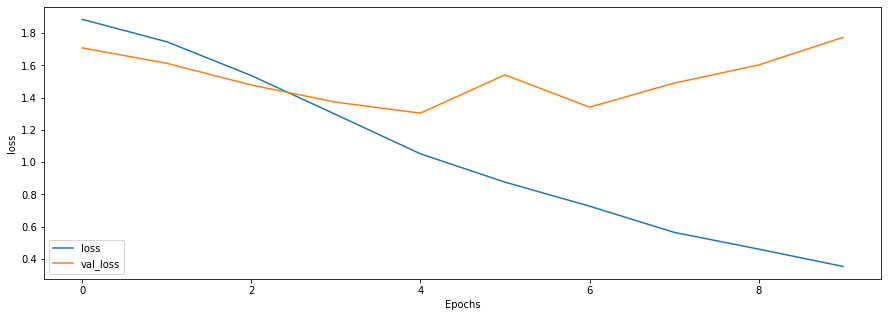

In [29]:
def plot_graphs(history, string):
  fig = plt.figure(figsize=(15, 5))
  name_img = string + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight') 
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

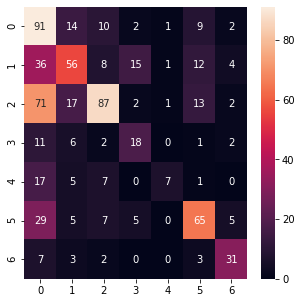

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(y_test, y_pred, metric, name_model)